# Logistic Regression Model
1. Build baseline LR
2. Over sampling with SMOTE
3. Under sampling with RandomSampler
4. Compare performance of all three models
5. Use Grid Search to tune hyperparameters
6. Compare all the models and save the model with best performance
7. Store all models' metrics to an excel file for report

## Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
# import tfidf
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,TfidfTransformer
# import train test split
from sklearn.model_selection import train_test_split, GridSearchCV
# import pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Read preprocessed train data (X & Y)

In [ ]:
path = '/content/drive/MyDrive/Guvi Files/Final Project2-V2/'

df = pd.read_pickle(path + 'data/train_tweets_clean.pkl')
train_y = df['label']
train_x = df['lem_tweet']
#

In [ ]:
print(train_x)

0        father dysfunctional selfish drag kid dysfunct...
1        thanks lyft credit cant use cause dont offer w...
2                                           bihday majesty
3                              model love u take u time ur
4                            factsguide society motivation
                               ...                        
31956          fishing tomorrow carnt wait first time year
31957                                        ate isz youuu
31958    see nina turner airwave trying wrap mantle gen...
31959       listening sad song monday morning otw work sad
31961                                         thank follow
Name: lem_tweet, Length: 29530, dtype: object


In [ ]:
#stop words
stop_words = stopwords.words('english')

## Split train & test from the training data (Note the actual test data given doesn't have label)

In [ ]:
# split train/test data
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=42)


## Vectorize using TFIDF

In [ ]:
#vectorize using TFIDFVectorizer
tfidf = TfidfVectorizer(stop_words=stop_words,ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

## Store tfidf on training data in a file.. will need it during prection scripts

In [ ]:
# Write vectorizer object in a pickle file for later use
with open(path + 'data/train_tfidf.pkl', 'wb') as file:
    pickle.dump(tfidf, file)

### Check for class imbalance

In [ ]:
#processed data is in list format.. conver to df
X_train_df = pd.DataFrame(data = X_train_tfidf, index= None, columns= ['tweet'])
training_data = pd.concat([X_train_df, y_train], axis=1)
training_data.head()


,tweet,label
0,"(0, 15008)\t0.275785229936426\n (0, 59048)\...",0.0
1,"(0, 89008)\t0.34299554014799666\n (0, 45398...",0.0
2,"(0, 154340)\t0.308416768980807\n (0, 28977)...",0.0
3,"(0, 90696)\t0.4037679544235627\n (0, 85457)...",NaN
4,"(0, 123256)\t0.2718471444797698\n (0, 75776...",0.0


In [ ]:
#separate labels (hate & non-hate)
hate = training_data[training_data['label']==1]
non_hate = training_data[training_data['label']==0]

In [ ]:
print(hate.shape, non_hate.shape)

(1605, 2) (22019, 2)


### there is class imbalance in hate & non-hate classes

## Build model before Over/Under sampling the classes

## Base Logistic Regression Model

In [ ]:
# fit the model
lr_base = LogisticRegression(penalty='l2',class_weight='balanced',random_state=20)
lr_base.fit(X_train_tfidf, y_train)


LogisticRegression(class_weight='balanced', random_state=20)

In [ ]:
# predict with test
lr_base_pred = lr_base.predict(X_test_tfidf)


In [ ]:
# evaluation metrics
lr_base_accuracy = accuracy_score(y_test, lr_base_pred)
lr_base_precision = precision_score(y_test, lr_base_pred)
lr_base_recall = recall_score(y_test, lr_base_pred)
lr_base_f1 = f1_score(y_test, lr_base_pred)
lr_base_weighted_f1 = f1_score(y_test, lr_base_pred, average='weighted')

#print evaluation metrics
print('Accuracy:', lr_base_accuracy)
print('Precision:', lr_base_precision)
print('Recall:', lr_base_recall)
print('F1 Score:', lr_base_f1)
print('Weighted F1 Score:', lr_base_weighted_f1)

Accuracy: 0.9458178123941754
Precision: 0.5862745098039216
Recall: 0.7328431372549019
F1 Score: 0.6514161220043573
Weighted F1 Score: 0.9485742813146602


### Note to self on F1 Score -
- 0.0: The worst possible score, indicating that the model failed to identify any true positives
- 0.5–0.8: Considered average
- 0.8–0.9: Considered good
- 0.9 or higher: Considered excellent
- 0.7 or higher: Often considered good, but some applications may require a higher

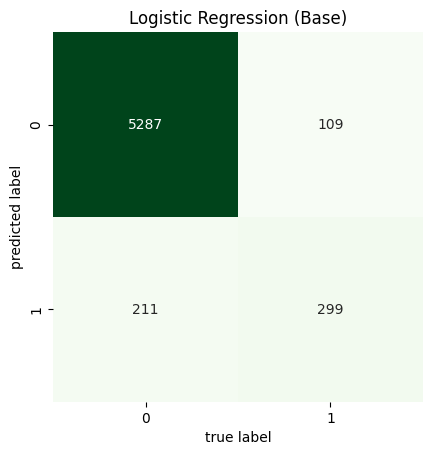

In [ ]:
# plot confusion matrix for predicted and actual
cm = confusion_matrix(y_test, lr_base_pred)
sns.heatmap(cm.T,square=True,annot=True,fmt='d', cbar=False,
             cmap="Greens")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Logistic Regression (Base)')
plt.show()

In [ ]:
# create a dictionary to store model evaluation parameters
lr_base_metrics = {}
lr_base_metrics['Logisitic Regression - Base'] = {'accuracy': lr_base_accuracy, 'precision': lr_base_precision, 'recall': lr_base_recall, 'f1_score': lr_base_f1, 'weighted_f1': lr_base_weighted_f1}
lr_base_metrics


{'Logisitic Regression - Base': {'accuracy': 0.9458178123941754,
  'precision': 0.5862745098039216,
  'recall': 0.7328431372549019,
  'f1_score': 0.6514161220043573,
  'weighted_f1': 0.9485742813146602}}

## Logistic Regression with SMOTE (Over-sample the minority class)

In [ ]:
#import smote
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train_tfidf, y_train)

In [ ]:
lr_smote = LogisticRegression(penalty='l2',class_weight='balanced',random_state=20)
lr_smote.fit(X_train_smote, y_train_smote)

LogisticRegression(class_weight='balanced', random_state=20)

In [ ]:
# Predict with lr_smote
lr_smote_pred = lr_smote.predict(X_test_tfidf)

In [ ]:
# model evaluation metrics
lr_smote_accuracy = accuracy_score(y_test, lr_smote_pred)
lr_smote_precision = precision_score(y_test, lr_smote_pred)
lr_smote_recall = recall_score(y_test, lr_smote_pred)
lr_smote_f1 = f1_score(y_test, lr_smote_pred)
lr_smote_weighted_f1 = f1_score(y_test, lr_smote_pred, average='weighted')

#print evaluation metrics
print('Accuracy:', lr_smote_accuracy)
print('Precision:', lr_smote_precision)
print('Recall:', lr_smote_recall)
print('F1 Score:', lr_smote_f1)
print('Weighted F1 Score:', lr_smote_weighted_f1)

Accuracy: 0.941246190314934
Precision: 0.5551537070524413
Recall: 0.7524509803921569
F1 Score: 0.6389177939646202
Weighted F1 Score: 0.9452861513757391


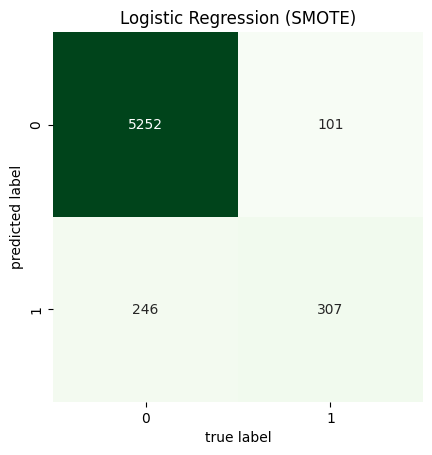

In [ ]:
# plot confusion matrix for smote model
cm = confusion_matrix(y_test, lr_smote_pred)
sns.heatmap(cm.T,square=True,annot=True,fmt='d', cbar=False,
             cmap="Greens")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Logistic Regression (SMOTE)')
plt.show()

In [ ]:
# Create dict to store SMOTE model metrics
lr_base_metrics['Logisitic Regression - SMOTE'] = {'accuracy': lr_smote_accuracy, 'precision': lr_smote_precision, 'recall': lr_smote_recall, 'f1_score': lr_smote_f1, 'weighted_f1': lr_smote_weighted_f1}
lr_base_metrics


{'Logisitic Regression - Base': {'accuracy': 0.9458178123941754,
  'precision': 0.5862745098039216,
  'recall': 0.7328431372549019,
  'f1_score': 0.6514161220043573,
  'weighted_f1': 0.9485742813146602},
 'Logisitic Regression - SMOTE': {'accuracy': 0.941246190314934,
  'precision': 0.5551537070524413,
  'recall': 0.7524509803921569,
  'f1_score': 0.6389177939646202,
  'weighted_f1': 0.9452861513757391}}

## Logistic Regression with Under-Sampling (RandomSampler)

In [ ]:
# import randomsampler
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_tfidf, y_train)


In [ ]:
print(X_train_rus)

  (0, 9433)	0.3847157306403393
  (0, 141299)	0.3847157306403393
  (0, 55267)	0.3847157306403393
  (0, 18862)	0.3847157306403393
  (0, 26500)	0.32504711355896715
  (0, 141298)	0.3847157306403393
  (0, 18846)	0.26612749561426435
  (0, 9420)	0.22995367760776786
  (0, 55033)	0.1749596215961724
  (1, 18038)	0.2364672296677928
  (1, 82055)	0.2364672296677928
  (1, 99881)	0.2364672296677928
  (1, 6482)	0.2364672296677928
  (1, 78757)	0.2364672296677928
  (1, 82486)	0.2364672296677928
  (1, 18039)	0.2364672296677928
  (1, 82057)	0.2364672296677928
  (1, 82054)	0.2364672296677928
  (1, 78756)	0.2364672296677928
  (1, 18037)	0.4729344593355856
  (1, 82056)	0.2364672296677928
  (1, 13584)	0.19979164960805468
  (1, 6481)	0.21558696219352785
  (1, 99798)	0.12884142586350184
  (1, 13337)	0.21678110253205488
  :	:
  (3208, 3273)	0.1958935038589262
  (3208, 82592)	0.24618130922875484
  (3208, 126131)	0.19934403344643256
  (3208, 56650)	0.1271752058534493
  (3208, 82317)	0.11496507560279877
  (3208, 15

In [ ]:
# fit model
lr_rus = LogisticRegression(penalty='l2',class_weight='balanced',random_state=20)
lr_rus.fit(X_train_rus, y_train_rus)

LogisticRegression(class_weight='balanced', random_state=20)

In [ ]:
# predict
lr_rus_pred = lr_rus.predict(X_test_tfidf)

In [ ]:
# model metrics
lr_rus_accuracy = accuracy_score(y_test, lr_rus_pred)
lr_rus_precision = precision_score(y_test, lr_rus_pred)
lr_rus_recall = recall_score(y_test, lr_rus_pred)
lr_rus_f1 = f1_score(y_test, lr_rus_pred)
lr_rus_weighted_f1 = f1_score(y_test, lr_rus_pred, average='weighted')

#print metrics
print('Accuracy:', lr_rus_accuracy)
print('Precision:', lr_rus_precision)
print('Recall:', lr_rus_recall)
print('F1 Score:', lr_rus_f1)
print('Weighted F1 Score:', lr_rus_weighted_f1)

Accuracy: 0.887571960717914
Precision: 0.3644067796610169
Recall: 0.8431372549019608
F1 Score: 0.5088757396449703
Weighted F1 Score: 0.9069774267308297


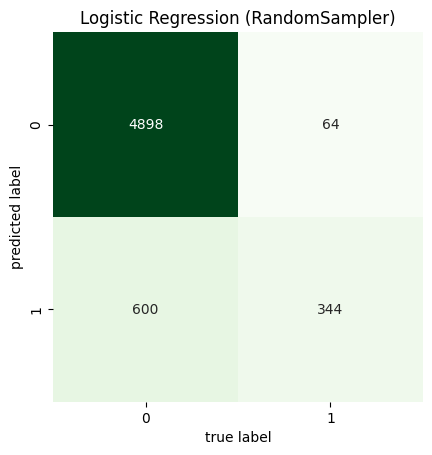

In [ ]:
# plot confusion metrics
cm = confusion_matrix(y_test, lr_rus_pred)
sns.heatmap(cm.T,square=True,annot=True,fmt='d', cbar=False,
             cmap="Greens")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Logistic Regression (RandomSampler)')
plt.show()

In [ ]:
# Create dict to store RadomUnderSampler model metrics
lr_base_metrics['Logisitic Regression - RUS'] = {'accuracy': lr_rus_accuracy, 'precision': lr_rus_precision, 'recall': lr_rus_recall, 'f1_score': lr_rus_f1, 'weighted_f1': lr_rus_weighted_f1}
pd.DataFrame.from_dict(lr_base_metrics, orient = 'index')

,accuracy,precision,recall,f1_score,weighted_f1
Logisitic Regression - Base,0.945818,0.586275,0.732843,0.651416,0.948574
Logisitic Regression - SMOTE,0.941246,0.555154,0.752451,0.638918,0.945286
Logisitic Regression - RUS,0.887572,0.364407,0.843137,0.508876,0.906977


## Conclusion 1:
* Logistic Regression (Base) model has the highest F1 Score & highest Precision
* Logistic Regression (RUS) model has the highest Recall but lowets F1 Score

## Hyperparameter tuning using GridSearchCV
* find best hyperparameters
* apply best hyperparameters to model & evaluate

In [ ]:
# build base model
lr_base1 = LogisticRegression(class_weight='balanced',random_state=20)

#parameters
param_grid = {'C': [0.01, 0.1, 1, 10],
              'penalty': ['l2'], 'solver':['liblinear','saga','newton-cg']}

# grid search
grid_search = GridSearchCV(lr_base1, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_tfidf, y_train)


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=20),
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'],
                         'solver': ['liblinear', 'saga', 'newton-cg']},
             scoring='f1')

In [ ]:
# generate score with .best_score_ and hyperparemeters with .best_params_
print('F1 Score:', grid_search.best_score_)
print('Best Hyperparameters:', grid_search.best_params_)
print('Model object with best parameters: ')
print(grid_search.best_estimator_)

F1 Score: 0.6444997501834673
Best Hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
Model object with best parameters: 
LogisticRegression(C=10, class_weight='balanced', random_state=20,
                   solver='saga')


In [ ]:
#predict train with best estimator
gs_pred_train = grid_search.best_estimator_.predict(X_train_tfidf)

#predict test with best params
gs_pred_test = grid_search.best_estimator_.predict(X_test_tfidf)


In [ ]:
# Print F1 score for prediction on train and test dataset
print('F1 Score on train dataset:', f1_score(y_train, gs_pred_train))
print('F1 Score on test dataset:', f1_score(y_test, gs_pred_test))

F1 Score on train dataset: 0.9843317972350231
F1 Score on test dataset: 0.6800472255017711


In [ ]:
# metrics for tuned model
tuned_accuracy = accuracy_score(y_test, gs_pred_test)
tuned_precision = precision_score(y_test, gs_pred_test)
tuned_f1 = f1_score(y_test, gs_pred_test)
tuned_recall = recall_score(y_test, gs_pred_test)
tuned_weighted_f1 = f1_score(y_test, gs_pred_test, average='weighted')

#print
print('Accuracy:', tuned_accuracy)
print('Precision:', tuned_precision)
print('Recall:', tuned_recall)
print('F1 Score:', tuned_f1)
print('Weighted F1 Score:', tuned_weighted_f1)

Accuracy: 0.9541144598713173
Precision: 0.6560364464692483
Recall: 0.7058823529411765
F1 Score: 0.6800472255017711
Weighted F1 Score: 0.9548892965576334


## Conclustion 2: Tuned hyperparameter gives better F1 on both train and test over the Base Models

## Apply tuned model on SMOTE data to check if we can further tune the model

In [ ]:
# Create model based on suggested best params
tuned_smote = LogisticRegression(C=10, class_weight='balanced', random_state=20,
                   solver='saga')
tuned_smote.fit(X_train_smote, y_train_smote)

LogisticRegression(C=10, class_weight='balanced', random_state=20,
                   solver='saga')

In [ ]:
# predict
tuned_smote_pred = tuned_smote.predict(X_test_tfidf)

In [ ]:
# evaluate model metrics
tuned_smote_accuracy = accuracy_score(y_test, tuned_smote_pred)
tuned_smote_precision = precision_score(y_test, tuned_smote_pred)
tuned_smote_f1 = f1_score(y_test, tuned_smote_pred)
tuned_smote_recall = recall_score(y_test, tuned_smote_pred)
tuned_smote_weighted_f1 = f1_score(y_test, tuned_smote_pred, average='weighted')

# print metrics
print('Accuracy:', tuned_smote_accuracy)
print('Precision:', tuned_smote_precision)
print('Recall:', tuned_smote_recall)
print('F1 Score:', tuned_smote_f1)
print('Weighted F1 Score:', tuned_smote_weighted_f1)

Accuracy: 0.9475110057568574
Precision: 0.6088888888888889
Recall: 0.6715686274509803
F1 Score: 0.6386946386946387
Weighted F1 Score: 0.9486950743543207


In [ ]:
# Create dict for tuned model metrics
tuned_metrics = {}
tuned_metrics['Tuned Model - Base Data'] = {'accuracy':tuned_accuracy,'precision': tuned_precision, 'recall': tuned_recall, 'f1_score': tuned_f1, 'weighted_f1': tuned_weighted_f1}
tuned_metrics['Tuned Model - SMOTE Data'] = {'accuracy': tuned_smote_accuracy, 'precision': tuned_smote_precision, 'recall': tuned_smote_recall, 'f1_score': tuned_smote_f1, 'weighted_f1': tuned_smote_weighted_f1}
pd.DataFrame.from_dict(tuned_metrics, orient = 'index')

#


,accuracy,precision,recall,f1_score,weighted_f1
Tuned Model - Base Data,0.954114,0.656036,0.705882,0.680047,0.954889
Tuned Model - SMOTE Data,0.947511,0.608889,0.671569,0.638695,0.948695


## Final Conclustion
* After Hyperparameter tuning, model on base data has better F1 score than on SMOTE.

## Save the best model - Logistic Regression Tuned Model on Base Data

In [ ]:
# Build model with tuned hyperparameters & base data
final_model = LogisticRegression(C=10, class_weight='balanced', random_state=20,
                   solver='saga')
final_model.fit(X_train_tfidf, y_train)

LogisticRegression(C=10, class_weight='balanced', random_state=20,
                   solver='saga')

In [ ]:
# predict on test
final_pred = final_model.predict(X_test_tfidf)

In [ ]:
# model metrics
final_accuracy = accuracy_score(y_test, final_pred)
final_precision = precision_score(y_test, final_pred)
final_f1 = f1_score(y_test, final_pred)
final_recall = recall_score(y_test, final_pred)
final_weighted_f1 = f1_score(y_test, final_pred, average='weighted')

#print
print('Accuracy:', final_accuracy)
print('Precision:', final_precision)
print('Recall:', final_recall)
print('F1 Score:', final_f1)
print('Weighted F1 Score:', final_weighted_f1)

Accuracy: 0.9541144598713173
Precision: 0.6560364464692483
Recall: 0.7058823529411765
F1 Score: 0.6800472255017711
Weighted F1 Score: 0.9548892965576334


In [ ]:
# save the model
with open(path + 'models/final_model_lr.pkl', 'wb') as file:
    pickle.dump(final_model, file)
#

In [ ]:
#write model metrics dict to an excel file
#append tuned model metrics to excel
# merge dicts lr_base_metrics & tuned_metrics
lr_base_metrics.update(tuned_metrics)

with pd.ExcelWriter(path + 'models/logistic_model_metrics.xlsx') as writer:
    df = pd.DataFrame.from_dict(lr_base_metrics, orient = 'index')
    df.to_excel(writer, sheet_name='Logistic Regression')
